# Pneumonia Detection from X-Ray Images DragoKami

## Import libraries

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms, models
from collections import OrderedDict
import json
import shutil
import numpy as np
import pandas as pd
import time
from torch import nn
from torch import optim
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import glob
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import os

## Get data from s3

In [4]:
#! aws s3 cp s3://ab-sagemaker-bucket/ ./ --recursive --endpoint-url https://s3-accelerate.amazonaws.com --region us-east-1

In [38]:
# Load the data
data_dir = 'chest_xray'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [39]:
# File route
train_normal = train_dir + '/0'
train_pneumonia = train_dir + '/1'

# Get the list of all the images
train_normal_list = glob.glob(train_normal + '/*.jpeg')
train_pneumonia_list = glob.glob(train_pneumonia + '/*.jpeg')
#print(train_normal_list)

# label the train data
df1 = pd.DataFrame(train_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(train_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_train = df1.append(df2).reset_index(drop = True)
df_train.columns = ('Pic','pneumonia')
df_train = df_train.sample(frac=1, random_state=2020).reset_index(drop=True) # shuffle the dataset
df_train.head()

,Pic,pneumonia
0,chest_xray/train/1/person596_bacteria_2443.jpeg,1.0
1,chest_xray/train/0/NORMAL2-IM-0501-0001.jpeg,0.0
2,chest_xray/train/1/person597_virus_1150.jpeg,1.0
3,chest_xray/train/0/NORMAL2-IM-0661-0001.jpeg,0.0
4,chest_xray/train/1/person645_virus_1226.jpeg,1.0


In [40]:
# Do the same thing to the validation and the test dataset
# File route
valid_normal = valid_dir + '/0'
valid_pneumonia = valid_dir + '/1'

# Get the list of all the images
valid_normal_list = glob.glob(valid_normal + '/*.jpeg')
valid_pneumonia_list = glob.glob(valid_pneumonia + '/*.jpeg')

# label the train data
df1 = pd.DataFrame(valid_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(valid_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_valid = df1.append(df2).reset_index(drop = True)
df_valid.columns = ('Pic','pneumonia')
df_valid = df_valid.sample(frac=1, random_state=20).reset_index(drop=True) # shuffle the dataset
df_valid.head()

,Pic,pneumonia
0,chest_xray/val/1/person1949_bacteria_4880.jpeg,1.0
1,chest_xray/val/0/NORMAL2-IM-1437-0001.jpeg,0.0
2,chest_xray/val/0/NORMAL2-IM-1438-0001.jpeg,0.0
3,chest_xray/val/1/person1954_bacteria_4886.jpeg,1.0
4,chest_xray/val/1/person1946_bacteria_4875.jpeg,1.0


In [41]:
# Test data
# File route
test_normal = test_dir + '/0'
test_pneumonia = test_dir + '/1'

# Get the list of all the images
test_normal_list = glob.glob(test_normal + '/*.jpeg')
test_pneumonia_list = glob.glob(test_pneumonia + '/*.jpeg')

# label the train data
df1 = pd.DataFrame(test_normal_list)
df1['pneumonia'] = np.zeros(len(df1))
df2 = pd.DataFrame(test_pneumonia_list)
df2['pneumonia'] = np.ones(len(df2))
df_test = df1.append(df2).reset_index(drop = True)
df_test.columns = ('Pic','pneumonia')
df_test = df_test.sample(frac=1, random_state=20).reset_index(drop=True) # shuffle the dataset
df_test.head()

,Pic,pneumonia
0,chest_xray/test/1/person85_bacteria_423.jpeg,1.0
1,chest_xray/test/0/NORMAL2-IM-0380-0001.jpeg,0.0
2,chest_xray/test/1/person1647_virus_2848.jpeg,1.0
3,chest_xray/test/1/person39_virus_85.jpeg,1.0
4,chest_xray/test/0/NORMAL2-IM-0229-0001.jpeg,0.0


Text(1, 3875, '3875')

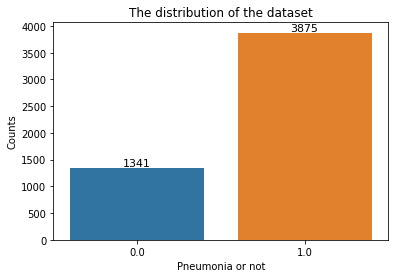

In [42]:
# Then we can see the distribution of our train dataset
counts = df_train.pneumonia.value_counts()
sns.barplot(x=counts.index, y= counts.values)
plt.title('The distribution of the dataset')
plt.xlabel('Pneumonia or not') 
plt.ylabel('Counts') 
plt.text(0,counts.values[1], '%.0f' % counts.values[1], ha='center', va= 'bottom',fontsize=11)  
plt.text(1,counts.values[0], '%.0f' % counts.values[0], ha='center', va= 'bottom',fontsize=11)

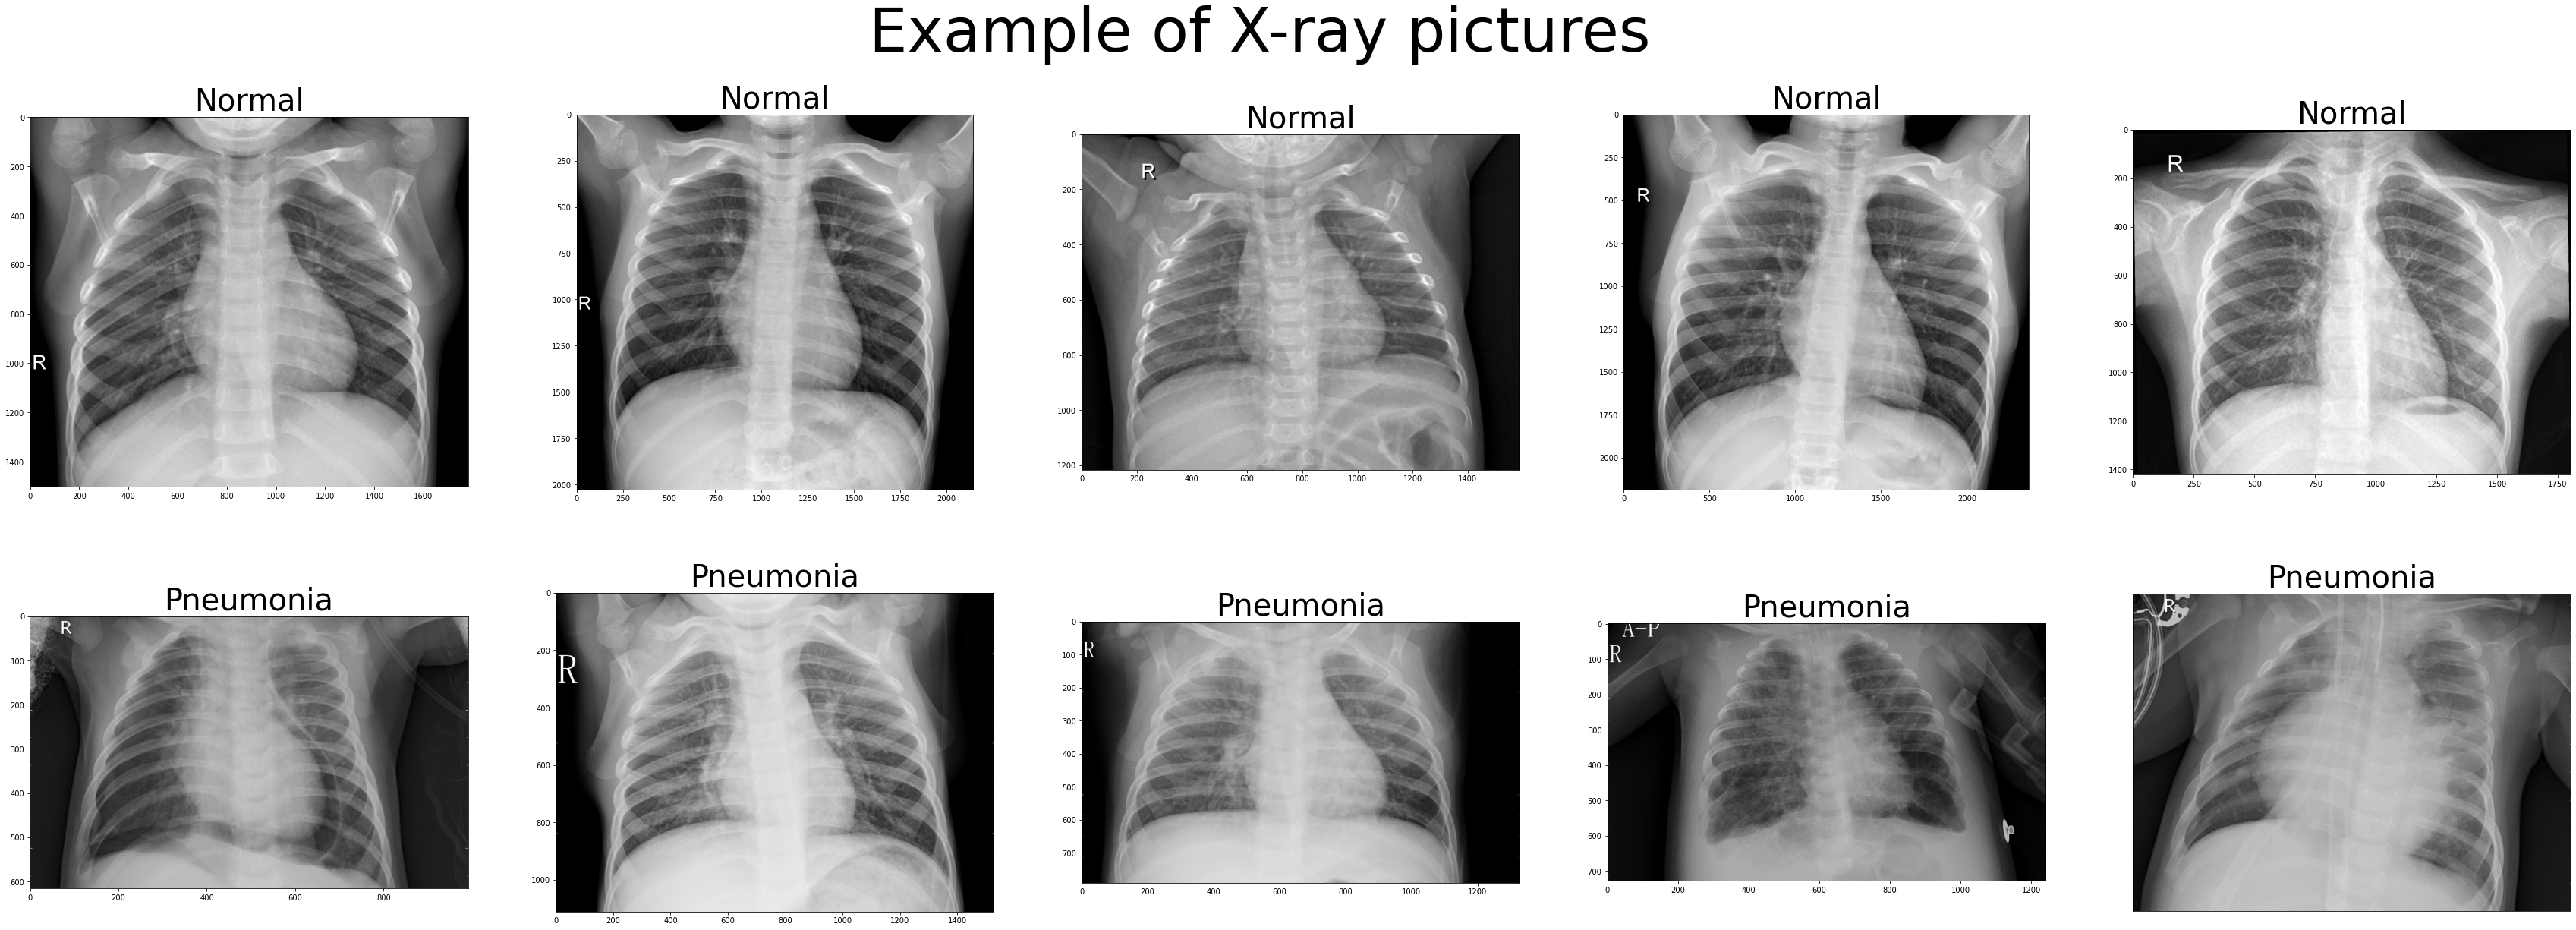

In [43]:
# Checking Images

pic_list = df_train[df_train['pneumonia']==0].head()['Pic']
pic_list = pic_list.append(df_train[df_train['pneumonia']==1].head()['Pic'])
pic_list = pic_list.reset_index(drop=True)

fig, ax = plt.subplots(2,5, figsize=(60,20))
for i in range(1,11):
    img = Image.open(pic_list[i-1])
    if i <= 5:
        ax[0,i-1].imshow(img, cmap='gray')
        ax[0,i-1].set_title('Normal',fontsize=40)
    else:
        ax[1,i-6].imshow(img, cmap='gray')
        ax[1,i-6].set_title('Pneumonia',fontsize=40)
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Example of X-ray pictures', fontsize=80)
plt.show()

In [44]:
# create annotations for train 
train_annotations = []
for each in df_train['Pic']:
    each = each.strip('chest_xray/train/1/')
    each = each.strip('chest_xray/train/0/')
    train_annotations.append(each)
train_annotations = pd.DataFrame([train_annotations,df_train['pneumonia']]).T
train_annotations = dict(train_annotations.values.tolist())
len(train_annotations)

5216

In [45]:
# create annotations for validation
valid_annotations = []
for each in df_valid['Pic']:
    each = each.strip('chest_xray/val/1/')
    each = each.strip('chest_xray/val/0/')
    valid_annotations.append(each)
valid_annotations = pd.DataFrame([valid_annotations,df_valid['pneumonia']]).T
valid_annotations = dict(valid_annotations.values.tolist())
len(valid_annotations)

16

In [46]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in valid_annotations.items():
    all_annotations[key] = value
len(all_annotations)

5232

In [47]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

[0.0, 1.0]

Num of classes: 2


### Upload training data to S3

In [48]:
# session and role
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
container = sagemaker.image_uris.retrieve("image-classification", boto3.Session().region_name)
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


In [ ]:
### Copying and listing images in train and test 

In [58]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [51]:
#train_annotations

In [59]:
import re 
def prepare_data_train(annotations, key='train'):
    images = list(annotations.keys())
    #print(images)
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            match = re.match(r'person', image)
            if match:
                shutil.copy(os.path.join('chest_xray/train/1/', image), os.path.join(key, image))
            else:
                shutil.copy(os.path.join('chest_xray/train/0/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()
    
def prepare_data_valid(annotations, key='validation'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            match = re.match(r'person', image)
            if match:
                shutil.copy(os.path.join('chest_xray/val/1/', image), os.path.join(key, image))
            else:
                shutil.copy(os.path.join('chest_xray/val/0/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [60]:
prepare_data_train(train_annotations, 'train')

100%|██████████| 5216/5216 [03:08<00:00, 27.61it/s]


In [70]:
prepare_data_valid(valid_annotations, 'validation')

100%|██████████| 16/16 [00:00<00:00, 19.59it/s]


In [ ]:
# Uploading to S3

In [62]:
%%time

s3_train_path = sess.upload_data(path='train',bucket=bucket, key_prefix='train')
print('Training images uploaded')
s3_train_lst_path = sess.upload_data(path='train_lst',bucket=bucket, key_prefix='train_lst')
print('Training list uploaded')
s3_validation_path = sess.upload_data(path='validation',bucket=bucket, key_prefix='validation')
print('validation images uploaded')
s3_validation_lst_path = sess.upload_data(path='validation_lst',bucket=bucket, key_prefix='validation_lst')
print('Validation list uploaded')

Training images uploaded
Training list uploaded
validation images uploaded
Validation list uploaded
CPU times: user 34.2 s, sys: 5.41 s, total: 39.6 s
Wall time: 7min 56s


## Using Sagmaker Estimator

In [64]:
prefix = 'output'
output_path = 's3://{}/{}'.format(bucket, prefix)
model = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    max_run=36000,
    input_mode='File',
    output_path=output_path,
    sagemaker_session=sess
)

In [65]:
# Hyperparameters
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=2,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=5186,
    augmentation_type='crop_color_transform'
)

In [67]:
# Data channels
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
train_lst_data = sagemaker.inputs.TrainingInput(s3_train_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')
validation_lst_data = sagemaker.inputs.TrainingInput(s3_validation_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image',s3_data_type='S3Prefix')

In [68]:
data_channels = {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data
}

In [71]:
%%time
# Forgot to copy validation data, moving to S3 now
s3_validation_path = sess.upload_data(path='validation',bucket=bucket, key_prefix='validation')
print('validation images uploaded')
s3_validation_lst_path = sess.upload_data(path='validation_lst',bucket=bucket, key_prefix='validation_lst')
print('Validation list uploaded')

validation images uploaded
Validation list uploaded
CPU times: user 130 ms, sys: 24.2 ms, total: 154 ms
Wall time: 1.59 s


## Model Training

In [72]:
model.fit(inputs=data_channels,logs=True)

2022-07-28 19:59:17 Starting - Starting the training job...ProfilerReport-1659038357: InProgress
...
2022-07-28 20:00:01 Starting - Preparing the instances for training.........
2022-07-28 20:01:41 Downloading - Downloading input data.........
2022-07-28 20:03:13 Training - Downloading the training image...
2022-07-28 20:03:49 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[07/28/2022 20:03:56 INFO 140617542879040] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[07/28/2022 20:03:56 INFO 140617542879040] Merging with provided configuration from 

In [73]:
deployed_model = model.deploy(initial_instance_count=1,instance_type='ml.t2.medium')
print('\nModel deployed!')

-----------------!
Model deployed!


## Make Predictions

In [74]:
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
print(len(images))

234


In [79]:
#deployed_model.content_type = 'image/jpeg'

In [80]:
index = 233

image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
result = json.loads(result)
print(result)

[0.9057145714759827, 0.09428541362285614]


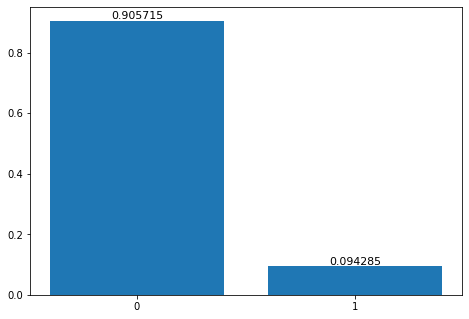

In [81]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0','1']
ax.bar(langs,result)
plt.text(0,result[0], '%f' % result[0], ha='center', va= 'bottom',fontsize=11)  
plt.text(1,result[1], '%f' % result[1], ha='center', va= 'bottom',fontsize=11) 
plt.show()

In [82]:
classes[np.argmax(result)]

0.0

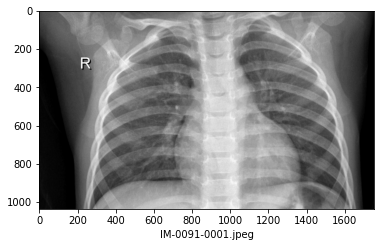

In [83]:
plt.imshow(plt.imread(image_path), cmap='gray')
plt.xlabel(images[index])
plt.show()

In [84]:
# Also try a pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
print(len(images))

390


In [85]:
index = 1
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
result = json.loads(result)
print(result)

[0.04599422588944435, 0.954005777835846]


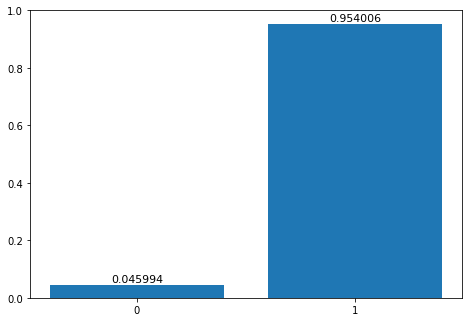

In [86]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0','1']
ax.bar(langs,result)
plt.text(0,result[0], '%f' % result[0], ha='center', va= 'bottom',fontsize=11)  
plt.text(1,result[1], '%f' % result[1], ha='center', va= 'bottom',fontsize=11) 
plt.show()

In [87]:
classes[np.argmax(result)]

1.0

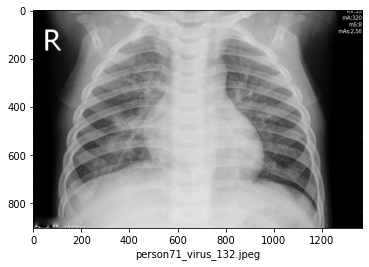

In [88]:
plt.imshow(plt.imread(image_path), cmap='gray')
plt.xlabel(images[index])
plt.show()

## Check Performance

In [90]:
# All should be zeros, which means normal
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
normals = []
for i in range(0,233):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
    result = json.loads(result)
    normals.append(classes[np.argmax(result)])

In [95]:
false_positives = sum(normals) 
true_negatives = len(normals) - false_positives

In [96]:
# All should be ones, which means pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']
pneumonia = []
for i in range(0,389):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
    result = json.loads(result)
    pneumonia.append(classes[np.argmax(result)])

In [97]:
true_positives = sum(pneumonia) 
false_negatives = len(pneumonia) - true_positives

In [98]:
df = pd.DataFrame({'predict 0': [true_negatives, false_negatives],
                   'predict 1': [false_positives, true_positives],},
                  index=['true 0','true 1'])
df

,predict 0,predict 1
true 0,231.0,2.0
true 1,57.0,332.0


In [99]:
# ratios
accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
recall = true_positives/(true_positives+false_negatives)
precision = true_positives/(true_positives+false_positives)
print("{:<11} {:.3f}".format('Accuracy:', accuracy))
print("{:<11} {:.3f}".format('Recall:', recall))
print("{:<11} {:.3f}".format('Precision:', precision))

Accuracy:   0.905
Recall:     0.853
Precision:  0.994


## Check if we can improve the accuracy

In [100]:
cutoff = 0.1 # set the cutoff value
# All should be zeros, which means normal
image_dir = 'chest_xray/test/0'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']

normals = []
for i in range(0,233):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
    result = json.loads(result)
    if result[1] > cutoff:
        normals.append(1)
    else:
        normals.append(0)
false_positives = sum(normals) 
true_negatives = len(normals) - false_positives

In [101]:
# All should be ones, which means pneumonia
image_dir = 'chest_xray/test/1'
images = [x for x in os.listdir(image_dir)  if x[-4:] == 'jpeg']

pneumonia = []
for i in range(0,389):
    index = i
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
    result = json.loads(result)
    if result[1] > cutoff:
        pneumonia.append(1)
    else:
        pneumonia.append(0)
true_positives = sum(pneumonia) 
false_negatives = len(pneumonia) - true_positives

In [102]:
df_new = pd.DataFrame({'predict 0': [true_negatives, false_negatives],
                   'predict 1': [false_positives, true_positives],},
                  index=['true 0','true 1'])
df_new

,predict 0,predict 1
true 0,202,31
true 1,13,376


In [103]:
# ratios
accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
recall = true_positives/(true_positives+false_negatives)
precision = true_positives/(true_positives+false_positives)
print("{:<11} {:.3f}".format('Accuracy:', accuracy))
print("{:<11} {:.3f}".format('Recall:', recall))
print("{:<11} {:.3f}".format('Precision:', precision))

Accuracy:   0.929
Recall:     0.967
Precision:  0.924


In [104]:
#sagemaker.Session().delete_endpoint(deployed_model.endpoint)

In [106]:
deployed_model.endpoint_name

'image-classification-2022-07-28-20-30-10-880'

## Check for one image

In [125]:
#Checking for pneumonia case
image_path = "chest_xray/val/1/person1954_bacteria_4886.jpeg"
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
str_res = result.decode('UTF-8')
score_list = re.findall(r'[\d\.\d]+', str_res)
print(f'Normal score is: {score_list[0]} and Pneumonia Score is : {score_list[1]}')

Normal score is: 0.07670906186103821 and Pneumonia Score is : 0.9232909679412842


In [124]:
#Checking for normal case
import re
image_path = "chest_xray/val/0/NORMAL2-IM-1436-0001.jpeg"
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
result = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg'})
str_res = result.decode('UTF-8')
score_list = re.findall(r'[\d\.\d]+', str_res)
print(f'Normal score is: {score_list[0]} and Pneumonia Score is : {score_list[1]}')

Normal score is: 0.9922657608985901 and Pneumonia Score is : 0.0077341580763459206
